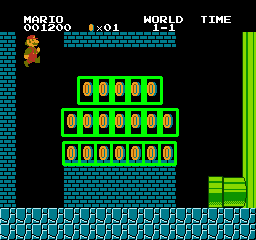

In [54]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from PIL import Image

def non_max_suppression(boxes, overlap_threshold=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_threshold)[0])))

    return boxes[pick].astype("int")

def skew_transform(image, skew_factor):
    """
    Apply skew transformation to the given image.
    """
    rows, cols = image.shape[:2]
    skew_matrix = np.float32([[1, skew_factor, 0], [0, 1, 0]])
    skewed_image = cv2.warpAffine(image, skew_matrix, (cols, rows))
    return skewed_image

# Read the main image
img_rgb = cv2.imread('/content/gdrive/MyDrive/mario.png')

# Convert it to RGB (PIL uses RGB)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

# Convert it to grayscale
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Read the template
template = cv2.imread('/content/gdrive/MyDrive/mario_coin3.png', 0)

# Define a range of scales to apply
scales = np.linspace(0.2, 2.0, 10)  # Adjust the range and number of scales as needed

# Perform multi-scale template matching with skew transformation
all_boxes = []
for scale in scales:
    resized_template = cv2.resize(template, (int(template.shape[1] * scale), int(template.shape[0] * scale)))

    # Apply skew transformation to the resized template
    skew_factor = 0.1 # Adjust the skew factor as needed
    skewed_template = skew_transform(resized_template, skew_factor)

    result = cv2.matchTemplate(img_gray, skewed_template, cv2.TM_CCOEFF_NORMED)

    # Set a threshold for matches
    threshold = 0.8
    # Get the locations where the correlation is above the threshold
    loc = np.where(result >= threshold)

    # Add bounding boxes to the list
    for pt in zip(*loc[::-1]):
        all_boxes.append((pt[0], pt[1], pt[0] + skewed_template.shape[1], pt[1] + skewed_template.shape[0]))

# Apply Non-Maximum Suppression
filtered_boxes = non_max_suppression(all_boxes)

# Draw rectangles around the matched regions
for box in filtered_boxes:
    cv2.rectangle(img_rgb, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

# Convert back to BGR for displaying with cv2_imshow
img_rgb_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# Show the final image
cv2_imshow(img_rgb_bgr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')